# Simple NN-CAOL Test

Example code for loading data, generating an instance of the acquisition model and loading one of the provided (i.e. trained) models

### 1) Load data and generate acquisition model

In [1]:
import torch
import torch.nn as nn

from networks.encoding_object import Dyn2DRadEncObj
from networks.caol_network import ConvAnaOpLearningCNN

from utils.noise_funcs import add_gaussian_noise
from utils.cplx_helper_funcs import cplx_np2torch, cplx_torch2np
import numpy as np
import matplotlib.pyplot as plt

#datatype
dtype = torch.float

#whether to use the gpu or not;
use_GPU=1

#load data
xf = np.load('toy_data/img_320.npy')
ktraj = np.load('toy_data/ktraj_320.npy') 
csm = np.load('toy_data/csmap_320.npy')
dcomp = np.load('toy_data/dcomp_320.npy')  #shape (Nrad,20)

#convert to tensors
xf_tensor = cplx_np2torch(xf,0).unsqueeze(0).unsqueeze(0) # (1,1,2,320,320,20)
ktraj_tensor = cplx_np2torch(ktraj,0).unsqueeze(0) # (1,2,11520,20)
csm_tensor = cplx_np2torch(csm,1).unsqueeze(0) #(1,12,2,320, 320)
dcomp_tensor = torch.tensor(dcomp).unsqueeze(0).unsqueeze(0).unsqueeze(0) 

#create encoding operator object
im_size = xf.shape

if use_GPU:
	xf_tensor = xf_tensor.to('cuda')
	ktraj_tensor = ktraj_tensor.to('cuda')
	csm_tensor = csm_tensor.to('cuda')
	dcomp_tensor = dcomp_tensor.to('cuda')
	
	EncObj = Dyn2DRadEncObj(im_size,ktraj_tensor,dcomp_tensor,csm_tensor,norm='ortho').cuda()
else:
	EncObj = Dyn2DRadEncObj(im_size,ktraj_tensor,dcomp_tensor,csm_tensor,norm='ortho')
print('acquisition model successfully generated')

acquisition model successfully generated


### 2) Define the reconstruction network
The network depends on the following hyper-parameters
- $n_u$ denotes the length of the network, i.e. the overall numbers of iterations
- $n_{\mathrm{CG}}$ denotes the number of iterations for the conjugate-gradient (CG)-module of the NN
- the number of filters (denoted by $K$ in the paper)
- the size of the filters (denoted by $k_f$ in the paper)

Further, we distinguish between two possible alternatives for the network: 
- "version1"
- "version2"

The difference between the two is given by the specifc steps which the the network alternates:

### Version 1 
This is the one used in our ISBI-paper and alternates between:
- $\mathbf{z}_j = \sum_k h_k^T \ast \mathcal{S}_{\alpha / \beta}(h_k \ast \mathbf{x})$ for all $k$
- solve $\mathbf{H}\mathbf{x} = \mathbf{b}$ with 
\begin{eqnarray}
\mathbf{H} &= &\mathbf{A}^\sharp\mathbf{A} + \lambda\, \mathbf{I}\\
\mathbf{b}_j &= &\mathbf{A}^\sharp\mathbf{y} + \lambda\, \mathbf{z}_j
\end{eqnarray}

### Version 2
Here, the two steps are given by
- $\mathbf{s}_k = \mathcal{S}_{\alpha / \beta}(h_k \ast \mathbf{x})$ for all $k$
- solve $\mathbf{H}\mathbf{x} = \mathbf{b}$ with 
\begin{eqnarray}
\mathbf{H} &= &\mathbf{A}^\sharp\mathbf{A} + \lambda\, \sum_k h_k^T \ast h_k\\
\mathbf{b} &= &\mathbf{A}^\sharp\mathbf{y} + \lambda\, \sum_k h_k^T \ast \mathbf{s}_k
\end{eqnarray}

Computationally, version 1 is favourable to train because $\mathbf{H}$ does not depend on the filters.
For version 2, we found it possible to include a unit-norm constraint on the filters which can be imposed by projecting them onto the unit-sphere after each weight updatae back-propagation. This possibly helps in in avoiding the scaling ambiguity between
the filters and the sparse coefficient maps

### Remark:
Currently, for version 2, we only have the configuration $K=16$ with $k_f=7$.

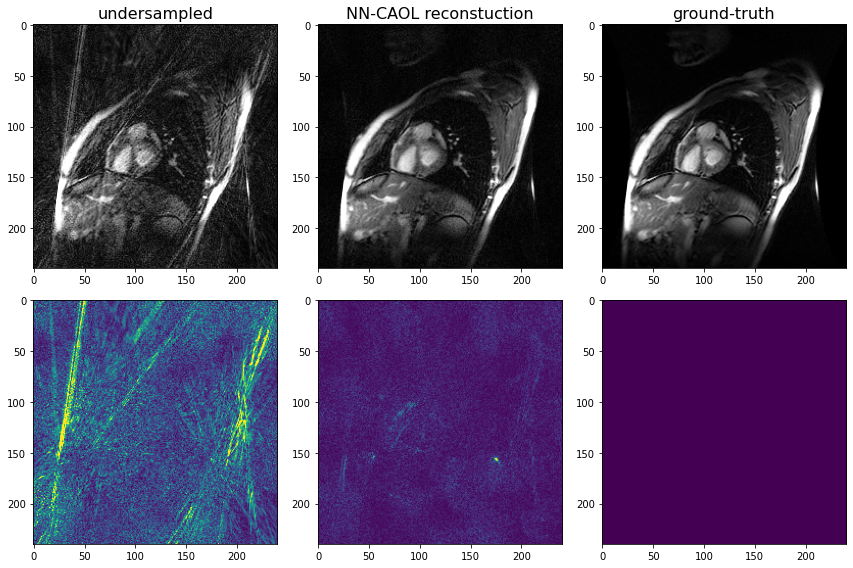

In [6]:
#define reconstruction network params
nu = 4
npcg = 4
n_filters = 16
kernel_size = 3
version = 'version1' #or version2 (see remark above)

caol_nn = ConvAnaOpLearningCNN(EncObj,
								nu=nu, 
								npcg=npcg, 
								n_filters=n_filters, 
								kernel_size=kernel_size,
								version=version)

if use_GPU:
	caol_nn = caol_nn.cuda()
	
#load pre-trained model
caol_nn.load_state_dict(torch.load('networks/pre_trained_models/caol_version1/nn_caol_K{}_k{}.pt'.format(n_filters, kernel_size)))

with torch.no_grad():
	#generate k-sace data, add noise
	ku_tensor = EncObj.apply_A(xf_tensor)
	ku_tensor = add_gaussian_noise(ku_tensor,sigma=.05)
	
	#get initial reconstruction
	xu_tensor = EncObj.apply_Adag(ku_tensor)
	
	xcnn_tensor = caol_nn(xu_tensor.squeeze(0))

xu = cplx_torch2np(xu_tensor.squeeze(0).squeeze(0).detach().cpu(),0)
xcnn = cplx_torch2np(xcnn_tensor.squeeze(0).detach().cpu(),0)

#create figure
arrs_list = [xu, xcnn, xf]
errs_list = [arr - xf for arr in arrs_list]
titles_list = ['undersampled', 'NN-CAOL reconstuction', 'ground-truth']
cutoff=40
figsize=4
fontsize=16
fig,ax=plt.subplots(2,len(errs_list),figsize=(figsize*3,figsize*2))
kt=12
for k in range(np.int(len(arrs_list))):
   	arr = arrs_list[k]
   	err = errs_list[k]
   	title = titles_list[k]
   	factor = 3.	
   	ax[0,k].imshow(np.abs(arr)[cutoff:-cutoff, cutoff:-cutoff, kt],cmap=plt.cm.Greys_r,clim=[0,1000])
   	ax[0,k].set_title(title,fontsize=fontsize)
   	ax[1,k].imshow(factor * np.abs(err)[cutoff:-cutoff, cutoff:-cutoff, kt],cmap=plt.cm.viridis,clim=[0,1000])
   	plt.tight_layout()